# Show the Singular Values profiles

In this notebook we upload an already trained model and we plot the profile of the Singular Values after .....

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# not mandatory
import io
from PIL import Image
from tqdm import tqdm

### Import the model

In [5]:
model_path = '/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'

Import the model and set the number of output classes as 100.

In [6]:
model = torchvision.models.vit_b_16()

in_features = model.heads.head.in_features
n_classes = 100		# do we have to import the dataset only to get the number of classes or can we just put 100 cause we know it's 100?
model.heads.head = torch.nn.Linear(in_features, n_classes)

In [7]:
checkpoint = torch.load(model_path,  weights_only=False, map_location='cpu')
model.load_state_dict(checkpoint['state_dict']) # load saved parameters (weights and biases)

<All keys matched successfully>

See if it prints the plots

In [8]:
image_bytes = checkpoint['loss_plot']
image = Image.open(io.BytesIO(image_bytes))
#image.show()  # this will open the image in the default image viewer (outside the notebook)

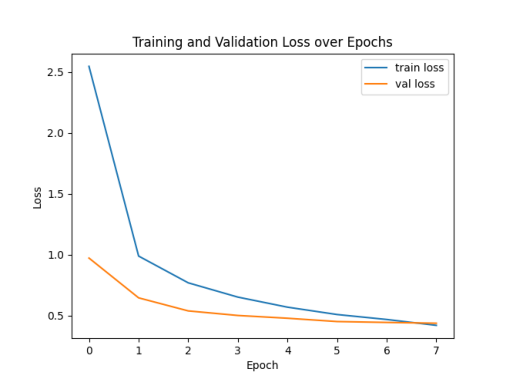

In [9]:
# alternatively, display the image inline (if in a notebook or interactive environment)
plt.imshow(image)
plt.axis('off')
plt.show()

Select the GPU

Is this part necessary for printing the sv profiles?

In [ ]:
# use_cuda = torch.cuda.is_available()
# cuda_index = torch.cuda.device_count() - 1
# device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
# print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# model.to(device)

### Pipeline only for the Head Layer

In [15]:
model.state_dict().keys()

odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.la

In [16]:
layer_name_w = 'heads.head.weight'
layer_name_b = 'heads.head.bias'

layer_w = model.state_dict()[layer_name_w]
layer_b = model.state_dict()[layer_name_b]

print('Weight shape: ', layer_w.shape)
print('Biases shape: ', layer_b.shape)

Weight shape:  torch.Size([100, 768])
Biases shape:  torch.Size([100])


In [17]:
# reshape the bias tensor
layer_b = layer_b.reshape(-1, 1)
print(layer_b.shape)

torch.Size([100, 1])


Now we concat the weights matrix and the bias array in a new matrix `A`

In [18]:
A = torch.cat((layer_w, layer_b), dim=1)

Compute SVD

In [19]:
U, s, V = torch.linalg.svd(A)
print(U.shape)
print(s.shape)
print(V.shape)

torch.Size([100, 100])
torch.Size([100])
torch.Size([769, 769])


We check that the approximation of the matrix `A` is good with norm.

The `torch.linalg.svd` return an array with the Singular Values, we need to build the augmented matrix and add the correct number of "zero rows".

In [20]:
# diag matrix
S = torch.diag(s)
print(S.shape)

# zeros matrix
S_zeros =torch.zeros(100,669)

# concat the 2 mat
S = torch.cat((S, S_zeros), dim=1)
print(S.shape)

torch.Size([100, 100])
torch.Size([100, 769])


In [21]:
# check with the norm if this is a good approx
torch.linalg.norm(A - (U @ S @ V))

tensor(8.9844e-06)

The distance is very small, so it's a good approximation.

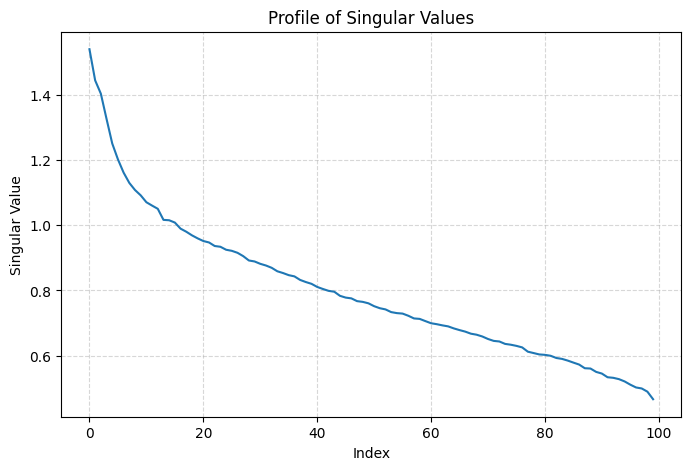

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(s.numpy())
plt.title('Profile of Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Loop on all layers

Do it for all the layers in the ViT

Do a for loop where we cycle through the `state dict` and we check for the shape of each layer, if it's a vector (e.g. [100]) we discard it, otherwise if it's a matrix we take it and save the corresponding biases. Then we proceed to to what we showed before in the previous section.


In [11]:
type(model.state_dict())

collections.OrderedDict

In [10]:
model.state_dict().keys()

odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.la

In [ ]:
layer = model._modules['encoder']._modules['layers']._modules['encoder_layer_10']._modules['mlp'][3] 
layer2 = model._modules['encoder']._modules['layers']._modules['encoder_layer_10']._modules['mlp']
   
print(layer)
print(layer2)
print(type(model._modules))


ciao
Linear(in_features=3072, out_features=768, bias=True)
MLPBlock(
  (0): Linear(in_features=768, out_features=3072, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=3072, out_features=768, bias=True)
  (4): Dropout(p=0.0, inplace=False)
)
<class 'dict'>


In [48]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

From here

In [ ]:
dictionary

{'conv_proj': Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16)),
 'encoder.layers.encoder_layer_0.ln_1': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_0.ln_2': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_0.mlp.0': Linear(in_features=768, out_features=3072, bias=True),
 'encoder.layers.encoder_layer_0.mlp.3': Linear(in_features=3072, out_features=768, bias=True),
 'encoder.layers.encoder_layer_0.self_attention.out_proj': NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True),
 'encoder.layers.encoder_layer_1.ln_1': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_1.ln_2': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_1.mlp.0': Linear(in_features=768, out_features=3072, bias=True),
 'encoder.layers.encoder_layer_1.mlp.3': Linear(in_features=3072, out_features=768, bias=True),
 'encoder.layers.encoder_laye

In [ ]:
st = list(model.state_dict().keys())

# remove .weight and .bias from the strings in the state_dict list
st_clean = [s.replace(".bias", "").replace(".weight", "") for s in st]
_st = sorted(list(set(st_clean)))


# input: model
#        layer_name: (string) layer i'm searching for
def get_layer(model, layer_name):
    keys = layer_name.split(".")
    temp = model
    for p in keys:
        #check that all the strings in parts are actually keys of the dict temp._modules
        if p not in temp._modules.keys():
            return None
        temp = temp._modules[p]
        
    return temp



_dict = {}

for layer_string in _st:
    layer = get_layer(model, layer_string)
    if layer != None:
        _dict[layer_string] = layer

_dict

{'conv_proj': Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16)),
 'encoder.layers.encoder_layer_0.ln_1': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_0.ln_2': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_0.mlp.0': Linear(in_features=768, out_features=3072, bias=True),
 'encoder.layers.encoder_layer_0.mlp.3': Linear(in_features=3072, out_features=768, bias=True),
 'encoder.layers.encoder_layer_0.self_attention.out_proj': NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True),
 'encoder.layers.encoder_layer_1.ln_1': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_1.ln_2': LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 'encoder.layers.encoder_layer_1.mlp.0': Linear(in_features=768, out_features=3072, bias=True),
 'encoder.layers.encoder_layer_1.mlp.3': Linear(in_features=3072, out_features=768, bias=True),
 'encoder.layers.encoder_laye

In [73]:
type(_dict['encoder.layers.encoder_layer_10.self_attention.out_proj'])

torch.nn.modules.linear.NonDynamicallyQuantizableLinear

### open file

In [78]:
path = '/home/saravorabbi/Documents/svd_prova/encoder.layers.encoder_layer_11.mlp.0/s.memmap'

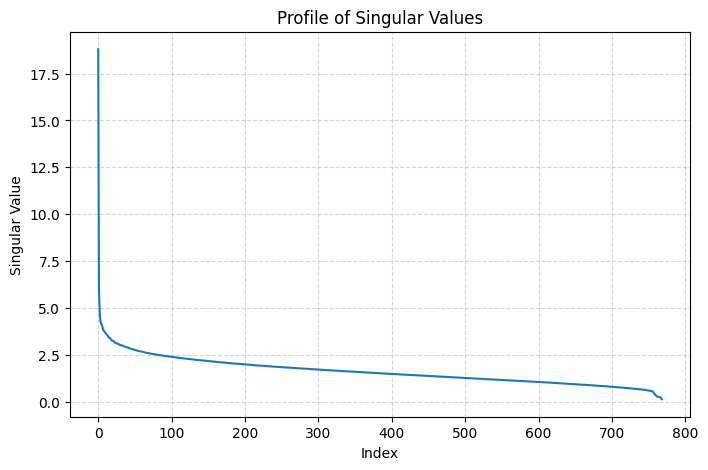

In [83]:
plt.figure(figsize=(8, 5))
plt.plot(s)
plt.title('Profile of Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Prove con il dataset

In [4]:
from datasets.cifar import Cifar

In [7]:
ds_path = '/srv/newpenny/dataset/CIFAR100'
dataset = 'CIFAR100'
seed=42

ds = Cifar(
    dataset=dataset,
    data_path=ds_path
    )
ds.load_data(
    dataset=dataset,
    batch_size=64,
    data_kwargs = {'num_workers': 8, 'pin_memory': True},
    seed=seed
)


dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f28a23196a0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f2899512b10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f289975d1f0>}

In [9]:
len(ds._classes)

100

In [25]:
dry_img = None

In [45]:
dry_img, _ = ds._train_ds.dataset[0]
type(ds._train_ds)


torch.utils.data.dataloader.DataLoader

In [44]:
print(type(ds._train_ds.dataset))
print(len(ds._train_ds.dataset))
print(type(ds._train_ds.dataset[0]))

<class 'torch.utils.data.dataset.Subset'>
40000
<class 'tuple'>


In [50]:
dry_img.shape

torch.Size([3, 224, 224])

In [51]:
dry_img_2 = dry_img.reshape((1,)+dry_img.shape)
dry_img_2.shape

torch.Size([1, 3, 224, 224])

## Prove xp_dummy

In [26]:
from pathlib import Path as Path
from time import time

from datasets.dummy import Dummy
from datasets.cifar import Cifar

from models.dummy_model import DummyModel
from models.model_wrap import ModelWrap
from models.svd import get_svds

from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn

from classifier.classifier_base import trim_corevectors
from classifier.tgmm import GMM as tGMM 


#from activations.activations import Activations
from peepholes.peepholes import Peepholes

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

In [27]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1  # 5
print('CUDA = ', cuda_index)
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

seed = 42
verbose = True
bs = 512

#--------------------------------
# Directories definitions
#--------------------------------
cvs_name = 'corevectors'
cvs_path = '/home/saravorabbi/Documents/corevectors'

phs_name = 'peepholes'
phs_path = '/home/saravorabbi/Documents/peepholes'

#--------------------------------
# Dataset 
#--------------------------------

ds_path = '/srv/newpenny/dataset/CIFAR100'
dataset = 'CIFAR100'

ds = Cifar(
    dataset=dataset,
    data_path=ds_path
    )
ds.load_data(
    dataset=dataset,
    batch_size=64,
    data_kwargs = {'num_workers': 8, 'pin_memory': True},
    seed=seed
)

#--------------------------------
# Model 
#--------------------------------

# experiment with ViT_b_16
model_dir = Path('/srv/newpenny/XAI/models/')
model_name = Path('SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth')
model_path = model_dir/model_name

nn = torchvision.models.vit_b_16()

# change the number of classes from 1000 to 100
n_classes = len(ds._classes)
in_features = nn.heads.head.in_features
nn.heads.head = torch.nn.Linear(in_features, n_classes)

# # ??
# if not model_path.exists():
#     torch.save({'state_dict': nn.state_dict()}, model_path)

# print to check
# for p in nn.parameters():
#     print('nn parameters: ', p)

wrap = ModelWrap(device=device)
wrap.set_model(
    model = nn,
    path = model_dir,
    name = model_name
)

# print to check
# for p in wrap._model.state_dict():
#     print('nn parameters: ', p)

# make list of target_layers
st_list = list(nn.state_dict().keys())
key_l = []
for elem in st_list:
    if len(nn.state_dict()[elem].shape) == 2:
        key_l.append(elem)
# remove .weight from the strings in the state_dict list
target_layers = [s.replace(".weight", "") for s in key_l]
target_layers = sorted(list(set(target_layers))) # unnecessary

# TODO filter out self_attention.out_proj layers 

isolated_target_layers = ['encoder.layers.encoder_layer_0.self_attention.out_proj'] 
target_layer_mlp0 = ['encoder.layers.encoder_layer_0.mlp.0']

#wrap.set_target_layers(target_layers=isolated_target_layers)
wrap.set_target_layers(target_layers=target_layer_mlp0)

direction = {'save_input':True, 'save_output':False}
wrap.add_hooks(**direction, verbose=verbose)

dry_img, _ = ds._train_ds.dataset[0]
dry_img = dry_img.reshape((1,)+dry_img.shape)
wrap.dry_run(x=dry_img)

#--------------------------------
# SVDs 
#--------------------------------
path_svd = Path('/home/saravorabbi/Documents/')
name_svd = 'svd_prova'
wrap.get_svds(path=path_svd, name=name_svd)
for k in wrap._svds.keys():
    for kk in wrap._svds[k].keys():
        print('svd shapes: ', k, kk, wrap._svds[k][kk].shape)



CUDA =  0
Using cuda:0 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


/home/saravorabbi/repos/XAI/src/models/model_wrap.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self.device)


Adding hook to layer:  encoder.layers.encoder_layer_0.mlp.0
in out shapes:  torch.Size([197, 768]) None
svd shapes:  encoder.layers.encoder_layer_0.mlp.0 U torch.Size([3072, 769])
svd shapes:  encoder.layers.encoder_layer_0.mlp.0 s torch.Size([769])
svd shapes:  encoder.layers.encoder_layer_0.mlp.0 Vh torch.Size([769, 769])
svd shapes:  encoder.layers.encoder_layer_0.mlp.3 U torch.Size([768, 768])
svd shapes:  encoder.layers.encoder_layer_0.mlp.3 s torch.Size([768])
svd shapes:  encoder.layers.encoder_layer_0.mlp.3 Vh torch.Size([768, 3073])
svd shapes:  encoder.layers.encoder_layer_4.mlp.3 U torch.Size([768, 768])
svd shapes:  encoder.layers.encoder_layer_4.mlp.3 s torch.Size([768])
svd shapes:  encoder.layers.encoder_layer_4.mlp.3 Vh torch.Size([768, 3073])
svd shapes:  encoder.layers.encoder_layer_10.mlp.3 U torch.Size([768, 768])
svd shapes:  encoder.layers.encoder_layer_10.mlp.3 s torch.Size([768])
svd shapes:  encoder.layers.encoder_layer_10.mlp.3 Vh torch.Size([768, 3073])
svd s

In [67]:
#--------------------------------
# CoreVectors 
#--------------------------------

ds_loaders = ds.get_dataset_loaders()

corevecs = CoreVectors(
    path = cvs_path,
    name = cvs_name,
    model = wrap,
    device = device
    )

with corevecs as cv: 
    # copy dataset to coreVect dataset
    cv.get_coreVec_dataset(
        loaders = ds_loaders,
        verbose = verbose
        )
    cv.get_activations(
        batch_size = 512,
        loaders = ds_loaders,
        verbose = verbose
        )
    cv.get_coreVectors(
        batch_size = 512,
        reduct_matrices = wrap._svds,
        parser = parser_fn,
        verbose = verbose
        )        

    cv_dl = cv.get_dataloaders(verbose=verbose)
    act = cv._actds



    print('ACT KEYS = ', act['train'].keys())
    print('TIPO = ', type(act))
    in_activations = act['train']['in_activations']
    nested_keys = in_activations.keys()  # Check nested keys
    print("Nested keys:", nested_keys)
    #print('ACT = ', act['train'][in_activations])
    if isinstance(in_activations, torch.Tensor):
        numpy_data = in_activations.detach().cpu().numpy()
        print('SONO DENTROOOO')
        print("Numpy array:", numpy_data)


    #print some activations 
    #for p in act['train']['in_activations']

    i = 0
    print('\nPrinting some corevecs')
    for data in cv_dl['train']:
        #print(data[in_]
        print(data['coreVectors']['encoder.layers.encoder_layer_0.mlp.0'][34:56,:])
        i += 1
        if i == 3: break

    cv.normalize_corevectors(
            wrt='train',
            verbose=verbose
            )
    i = 0
    print('after norm')
    for data in cv_dl['train']:
        print(data['coreVectors']['encoder.layers.encoder_layer_0.mlp.0'][34:56,:])
        i += 1
        if i == 3: break

Establishing connection... - _is_contexted set True

 ---- Getting data from train

File /home/saravorabbi/Documents/corevectors/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /home/saravorabbi/Documents/corevectors/corevectors.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /home/saravorabbi/Documents/corevectors/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting activations for train

N SAMPLES 40000
File /home/saravorabbi/Documents/corevectors/corevectors.activations.train exists. Loading from disk.
loaded /home/saravorabbi/Documents/corevectors/corevectors.activations.train
In activations exist.
Out activations exist.
Layers to save:  []
No new activations for train, skipping

 ---- Getting activations for val

N SAMPLES 10000
File /home/saravorabbi/Documents/corevectors/corevectors.activations.val exists. Loading from disk.
loaded /home/saravorabbi

/home/saravorabbi/repos/XAI/src/coreVectors/coreVectors.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  means, stds, is_normed, _wrt = torch.load(file_path)


In [48]:
type(act['train'])

tensordict.persistent.PersistentTensorDict

In [54]:
act_train = act['train']
print(type(act_train))
print(dir(act_train))  # List available methods and attributes

<class 'tensordict.persistent.PersistentTensorDict'>
['LOCKING', '_MutableMapping__marker', '__abs__', '__abstractmethods__', '__add__', '__annotations__', '__bool__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getitems__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__or__', '__pow__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__torch_function__', '__truediv__', '__weakref__', '__xor__', '_abc_impl', '_add_batch_dim', '_apply_nest', '_batch_size', '_batch_size_setter', '_cache', '_cast_reduction', '_change_batch

In [56]:
act['train'].keys()

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

In [59]:
act['train']['in_activations']

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

In [39]:
dataset = cv_dl['train'].dataset
print(dataset.keys())

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

In [10]:
act.shape

(40000, 197, 768)

In [ ]:
cv_dl[]

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1b04e475f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f1b04e47f50>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f1c929ba1b0>}

In [37]:
cv_dl['train'].dataset.keys()

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

In [ ]:
cv_dl['train'].dataset['in_activations']['encoder.layers.encoder_layer_0.mlp.0'].detach().cpu().numpy()

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

In [30]:
#--------------------------------
# Peepholes
#--------------------------------
n_classes = 100
parser_cv = trim_corevectors
peep_layer = 'encoder.layers.encoder_layer_0.mlp.0'
parser_kwargs = {'layer': peep_layer, 'peep_size':100}
cls_kwargs = {}#{'batch_size':256} 
cls = tGMM(
        nl_classifier = 100,
        nl_model = n_classes,
        parser = parser_cv,
        parser_kwargs = parser_kwargs,
        cls_kwargs = cls_kwargs,
        device = device
        )

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        )

peepholes = Peepholes(
        path = phs_path,
        name = phs_name+'.'+peep_layer,
        classifier = cls,
        layer = peep_layer,
        device = device
        )

with corevecs as cv, peepholes as ph:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            ) 

    cv_dl = cv.get_dataloaders(
            batch_size = bs,
            verbose = True,
            )

    t0 = time()
    cls.fit(dataloader = cv_dl['train'], verbose=verbose)
    print('Fitting time = ', time()-t0)
    
    cls.compute_empirical_posteriors(verbose=verbose)

    ph.get_peepholes(
            loaders = cv_dl,
            verbose = verbose
            )

    ph.get_scores(
        batch_size = bs,
        verbose=verbose
        )

    i = 0
    print('\nPrinting some peeps')
    ph_dl = ph.get_dataloaders(verbose=verbose)
    for data in ph_dl['test']:
        print('phs\n', data[peep_layer]['peepholes'])
        print('max\n', data[peep_layer]['score_max'])
        print('ent\n', data[peep_layer]['score_entropy'])
        i += 1
        if i == 3: break

    ph.evaluate_dists(
            score_type = 'max',
            coreVectors = cv_dl,
            bins = 20
            )

Establishing connection... - _is_contexted set True

 ---- Getting data from train

File /home/saravorabbi/Documents/corevectors/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /home/saravorabbi/Documents/corevectors/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /home/saravorabbi/Documents/corevectors/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
Loading normalization info.
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val

 ---- GMM classifier

Parsing data
Fitting GMM


../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [0,0,0], thread: [0,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [0,0,0], thread: [1,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [0,0,0], thread: [2,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [0,0,0], thread: [3,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [0,0,0], thread: [4,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [0,0,0], t

Closing connection...
closing train
closing test
closing val


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
